In [5]:
from datascience import *
import numpy as np
import random
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import os

listings = Table().read_table("data/listings.csv")
ratings = Table().read_table("data/ratings.csv")
calendar = Table().read_table("data/calendar.csv")

master_table_file = 'data/master.csv'

if not os.path.isfile(master_table_file):
    listings = Table().read_table("data/listings.csv")
    listings = listings.drop('amenities')
    listings = listings.drop('name')
    listings.relabel('id', 'listing_id')
    
    master_table = listings.join('listing_id', calendar).join('listing_id', ratings)
    master_table.to_csv('data/master.csv')
else:
    master_table = Table().read_table('data/master.csv')

master_table.show(5)


C:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


listing_id,host_id,host_name,host_since,host_is_superhost,neighbourhood,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,cleaning_fee,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,instant_bookable,is_business_travel_ready,calculated_host_listings_count,reviews_per_month,neighborhood,date,available,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
5858,8904,Philip And Tania,2009-03-02,f,Bernal Heights,94110,37.7451,-122.421,t,Apartment,Entire home/apt,5,1,2,3,100,30,60,0,0,0,0,111,2009-05-03,2017-08-06,f,f,1,0.82,Bernal Heights,2020-06-08,t,235,98,10,10,10,10,10,9
5858,8904,Philip And Tania,2009-03-02,f,Bernal Heights,94110,37.7451,-122.421,t,Apartment,Entire home/apt,5,1,2,3,100,30,60,0,0,0,0,111,2009-05-03,2017-08-06,f,f,1,0.82,Bernal Heights,2020-06-09,t,235,98,10,10,10,10,10,9
5858,8904,Philip And Tania,2009-03-02,f,Bernal Heights,94110,37.7451,-122.421,t,Apartment,Entire home/apt,5,1,2,3,100,30,60,0,0,0,0,111,2009-05-03,2017-08-06,f,f,1,0.82,Bernal Heights,2020-06-10,t,235,98,10,10,10,10,10,9
5858,8904,Philip And Tania,2009-03-02,f,Bernal Heights,94110,37.7451,-122.421,t,Apartment,Entire home/apt,5,1,2,3,100,30,60,0,0,0,0,111,2009-05-03,2017-08-06,f,f,1,0.82,Bernal Heights,2020-06-11,t,235,98,10,10,10,10,10,9
5858,8904,Philip And Tania,2009-03-02,f,Bernal Heights,94110,37.7451,-122.421,t,Apartment,Entire home/apt,5,1,2,3,100,30,60,0,0,0,0,111,2009-05-03,2017-08-06,f,f,1,0.82,Bernal Heights,2020-06-12,t,235,98,10,10,10,10,10,9


# Data Exploration

## Data Exploration - Rental Types
Let's try to figure out how many listings categories are there.

C:\Python38\lib\site-packages\datascience\tables.py:120: FutureWarning: Table.from_columns_dict is deprecated. Use Table().with_columns(...)
  warnings.warn("Table.from_columns_dict is deprecated. Use Table().with_columns(...)", FutureWarning)


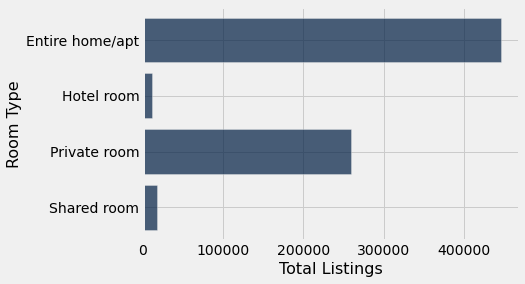

In [6]:
def plot_room_type():
    room_types = np.unique(master_table.column('room_type'))
    room_num_listings = make_array()

    for room_type in room_types:
        total_listings = master_table.where('room_type', are.equal_to(room_type)).num_rows
        room_num_listings = np.append(room_num_listings, total_listings)

    Table().from_columns_dict({
        'Room Type': room_types,
        'Total Listings': room_num_listings
    }).barh('Room Type', 'Total Listings')

plot_room_type()

It appears that there are two basic categories: private rooms, and whole apartments.

These two should be analyzed separately, because they have different properties. For example, it is reasonable to
expect that the size of a house would affect price more when you rent the whole house, rather than a single room
in the house.

In [7]:
master_entire_apt = master_table.where('room_type', are.equal_to('Entire home/apt'))

master_single_room = master_table.where('room_type', are.equal_to('Private room'))


## Data Exploration - Price Distribution

### Whole-apartment rentals


Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
price,246.51,166.436,10,999,78,132,195,300,749


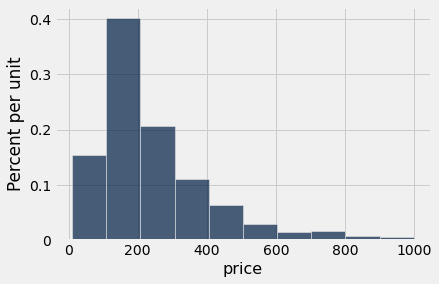

In [8]:
def inspect_column(tbl, column_name, draw_chart=True, draw_table=False):
    if draw_chart: tbl.hist(column_name)

    data = tbl.column(column_name)

    result = Table().with_columns(
        'Column', column_name,
        'Mean', np.mean(data),
        'Std', np.std(data),
        'Min', np.min(data),
        'Max', np.max(data),
        '2.5th Percentile', percentile(2.5, data),
        '25th Percentile', percentile(25, data),
        '50th Percentile', percentile(50, data),
        '75th Percentile', percentile(75, data),
        '97.5th Percentile', percentile(97.5, data),
    )
    if draw_table: result.show()

    return result

inspect_column(master_entire_apt, 'price', True)


### Single-room rentals


Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
price,125.552,89.8482,10,999,45,75,102,145,351


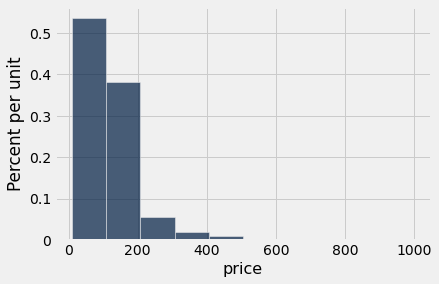

In [9]:
inspect_column(master_single_room, 'price', True)

  
## Data Exploration - Review Scores

Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
review_scores_rating,95.7674,7.95352,20,100,80,95,98,100,100


Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
review_scores_accuracy,9.80056,0.666573,2,10,8,10,10,10,10


Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
review_scores_cleanliness,9.6704,0.787594,2,10,8,10,10,10,10


Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
review_scores_checkin,9.85046,0.620357,2,10,8,10,10,10,10


Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
review_scores_communication,9.81596,0.718874,2,10,8,10,10,10,10


Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
review_scores_location,9.67206,0.905179,2,10,7,10,10,10,10


Column,Mean,Std,Min,Max,2.5th Percentile,25th Percentile,50th Percentile,75th Percentile,97.5th Percentile
review_scores_value,9.36178,0.943969,2,10,7,9,10,10,10


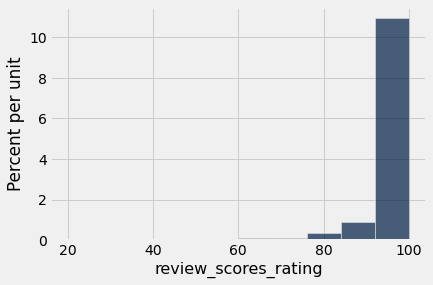

In [10]:
review_scores_columns = {
    'review_scores_rating': True,
    'review_scores_accuracy': False,
    'review_scores_cleanliness': False,
    'review_scores_checkin': False,
    'review_scores_communication': False,
    'review_scores_location': False,
    'review_scores_value': False,
}

for k,v in review_scores_columns.items():
    inspect_column(master_entire_apt, k, draw_chart=v, draw_table=True)



According to the basic stats above, _review_scores_rating_ is the only review field that provides reasonable resolution. The other fields have have a maximum of four values (7,8,9,10). Therefore, we will be focusing on _review_scores_rating_ as the primary source for review scores.

Additionally, it appears that people very rarely give review scores lower than 80.


# Research Question: Are Review Scores a Good Predictor for Price?


To start answering this question, we will run a basic correlation between review scores and listing price:

r = 0.16
r = 0.15


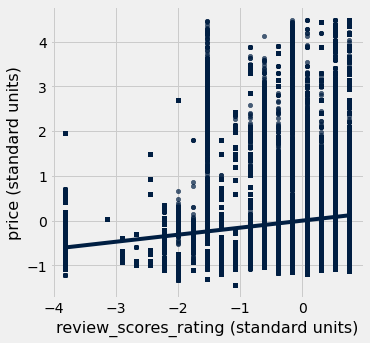

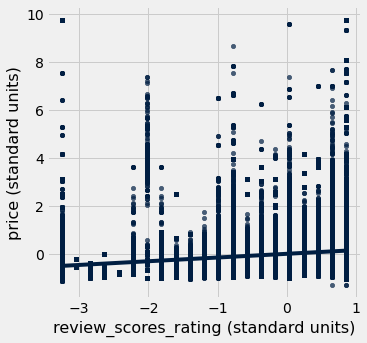

In [11]:
def remove_review_outliers(datasrc=None):
    if not datasrc: datasrc=master_entire_apt

    cutoff = percentile(
        2.5,    # We consider scores below the 2.5th percentile as outliers
        datasrc.column('review_scores_rating')
    )

    return datasrc.where(
        'review_scores_rating',
        are.above_or_equal_to(cutoff)
    )

def correlate(tbl, independent_name, dependent_name, draw=True):
    x_mean = np.mean(tbl.column(independent_name))
    x_std = np.std(tbl.column(independent_name))
    x_title = '%s (standard units)' % independent_name
    y_mean = np.mean(tbl.column(dependent_name))
    y_std = np.std(tbl.column(dependent_name))
    y_title = '%s (standard units)' % dependent_name

    standardized = Table().with_columns(
        x_title, (tbl.column(independent_name) - x_mean) / x_std,
        y_title, (tbl.column(dependent_name) - y_mean) / y_std)

    if draw:
        standardized.scatter(x_title, y_title, fit_line=True)

    return np.mean(standardized.column(0)*standardized.column(1))

##
## Review Score <-> Price correlation for Whole Apartment rentals
##
r = correlate(
    remove_review_outliers(master_entire_apt),
    'review_scores_rating',
    'price',
    draw=True
)
print('r = %.2f' % r)

##
## Review Score <-> Price correlation for Single Room rentals
##
r = correlate(
    remove_review_outliers(master_single_room),
    'review_scores_rating',
    'price',
    draw=True
)
print('r = %.2f' % r)

### Conclusion
Review scores are a poor predictor for listing price, with a correlation of 0.16 for whole-apartment rentals and 0.15 for single-room rentals.



# Research Question: Is Apartment Size a Good Predictor for Listing Price?

Next we explore the question of whether the size of an apartment is a good predictor for listing price.

This is a well-known dynamic in the real-estate market, that can be easily confirmed once you account for confounding factors such as location. We will test whether this holds true for Airbnb, for both whole-apartment and single-room rentals.

## Simple Correlation Between 'accomodates' and 'price'


In [12]:
print(
    "Correlation between 'accomodates' and 'price' for whole-apt rentals is r={0}".format(
        correlate(master_entire_apt, 'accommodates', 'price', draw=False)
    )
)

print(
    "Correlation between 'accomodates' and 'price' for single-room rentals is r={0}".format(
        correlate(master_single_room, 'accommodates', 'price', draw=False)
    )
)

Correlation between 'accomodates' and 'price' for whole-apt rentals is r=0.5836894377495122
Correlation between 'accomodates' and 'price' for single-room rentals is r=0.3112768547980852



## How About When Taking Geography (Zipcode) Into Account?

Can we improve our accomodates-to-price correlation if we take into account geographic location? Let's run this
analysis by dividing the listings into geographic regions based on zipcode.

In [13]:
import scipy.stats

def normalize_zipcode(s):
    return s.replace('.0', '').replace('CA', '').replace(' ', '')

def accommodates_to_price_correlation_by_zipcode(datasrc=None):
    if datasrc is None:
        datasrc = master_entire_apt

    # Data cleaning -- Create a "filter" to make the zipcode field consistent
    all_zipcodes = np.unique(datasrc.column('zipcode'))
    flt = {}
    for zipcode in all_zipcodes:
        if 'nan' in zipcode: continue
        zip_norm = normalize_zipcode(zipcode)
        if not zip_norm in flt:
            flt[zip_norm] = ''
        flt[zip_norm] += str(zipcode)

    # Correlate 'accomodates' to 'price' per zipcode
    result = {
        'zipcode'     : make_array(),
        'r'           : make_array(),
        'num_listings': make_array(),
        'slope'       : make_array(),
        'intercept'   : make_array()
    }
    for zipcode in flt.keys():
        t = datasrc.where('zipcode', are.contained_in(flt[zipcode]))
        
        r = correlate(t, 'accommodates', 'price', draw=False)
        if np.isnan(r):
            continue

        result['zipcode']      = np.append(result['zipcode'], zipcode)
        result['r']            = np.append(result['r'], r)
        result['num_listings'] = np.append(result['num_listings'], t.num_rows)
        
        regress = scipy.stats.linregress(t.column('accommodates'), t.column('price'))
        result['slope']     = np.append(result['slope'], regress.slope)
        result['intercept'] = np.append(result['intercept'], regress.intercept)

    # Add indication of "area size" based on the number of listings in that area
    result['area_size'] = make_array()
    result['rtag'] = make_array()
    total_listings = np.sum(result['num_listings']) * 1.0
    for i in range(len(result['zipcode'])):
        zipcode      = result['zipcode'][i]
        num_listings = result['num_listings'][i]
        r            = result['r'][i]
        area_size    = num_listings / total_listings
        rtag         = math.fabs(r) * area_size

        result['area_size'] = np.append(result['area_size'], area_size)
        result['rtag'] = np.append(result['rtag'], rtag)

    return Table().from_columns_dict(result)


t1 = accommodates_to_price_correlation_by_zipcode(master_entire_apt)
t1.show(100)
r1 = np.sum(t1.column('rtag'))
print("Zip-code based avg. corr. between 'accomodates' and 'price' for whole-apt rentals is r={0}".format(r1))

t2 = accommodates_to_price_correlation_by_zipcode(master_single_room)
t2.show(100)
r2 = np.sum(t2.column('rtag'))
print("Zip-code based avg. corr. between 'accomodates' and 'price' for single-room rentals is r={0}".format(r2))


<ipython-input-11-9a6deac88608>:23: RuntimeWarning: invalid value encountered in true_divide
  x_title, (tbl.column(independent_name) - x_mean) / x_std,


zipcode,r,num_listings,slope,intercept,area_size,rtag
94014,-0.992293,730,-294.76,2353.32,0.00163689,0.00162427
94102,0.678328,18615,57.2841,3.31626,0.0417406,0.0283138
94103,0.58411,20048,64.7904,41.494,0.0449538,0.026258
94105,0.746675,5462,73.314,56.3691,0.0122475,0.00914489
94107,0.728165,22422,71.4631,8.492,0.050277,0.03661
94108,0.472202,12214,77.4948,-25.9309,0.0273876,0.0129325
94109,0.714629,28102,97.1118,-92.5056,0.0630133,0.0450312
94110,0.717961,66371,52.8821,25.4961,0.148824,0.10685
94111,-0.409041,3650,-27.0292,274.535,0.00818443,0.00334777
94112,0.658905,20440,39.0601,17.2936,0.0458328,0.0301995


Zip-code based avg. corr. between 'accomodates' and 'price' for whole-apt rentals is r=0.6366290222469485


<ipython-input-11-9a6deac88608>:24: RuntimeWarning: invalid value encountered in true_divide
  y_title, (tbl.column(dependent_name) - y_mean) / y_std)


zipcode,r,num_listings,slope,intercept,area_size,rtag
94014,-0.106839,1095,-1.64041,64.0233,0.00423824,0.000452811
94102,0.749,18114,82.7154,-65.433,0.0701109,0.0525131
94103,0.376375,10949,97.4549,-23.7595,0.0423785,0.0159502
94105,-0.222953,1095,-16.0411,212.082,0.00423824,0.00094493
94107,0.507768,8760,38.6123,77.0534,0.0339059,0.0172163
94108,0.0467785,10568,5.07907,202.486,0.0409038,0.00191342
94109,0.714333,15843,90.456,-41.3047,0.0613209,0.0438036
94110,0.298352,35405,27.8342,74.9224,0.137036,0.040885
94112,0.708829,19710,30.5342,17.9791,0.0762883,0.0540754
94114,0.381,18980,26.6366,87.561,0.0734628,0.0279894


Zip-code based avg. corr. between 'accomodates' and 'price' for single-room rentals is r=0.3964901731319972


### Conclusion: Splitting by Geolocation Leads to Stronger Correlations
When taking zipcode into account, we get slightly better correlations:

For whole apartment rentals, our correlation score improved by **8.3%**

For single room rentals, our correlation score improved by **21.4%**


# Research Question: Are Listings by Superhosts More Expensive?


## Single-Sided Two-Means Hypothesis Test (n>30)

Null-hypothesis: Superhost status has no effect on price.

Alt-hypothesis: Listings by superhosts are more expensive.

H0: u1 - u2 <= 0

Ha: u1 - u2 > 0

In [14]:
import math
from scipy.stats import norm

def hypothesis_test_two_means(sample1, sample2, level_of_confidence=0.95, two_sided=False):
    assert len(sample1) > 30
    assert len(sample2) > 30

    z_score = (np.mean(sample1) - np.mean(sample2))
    z_score /= math.sqrt(
        ((np.std(sample1)**2) / len(sample1)) +
        ((np.std(sample2)**2) / len(sample2))
    )

    level_of_significance = 1.0 - level_of_confidence

    p_value = norm.sf(abs(z_score))

    if two_sided:
        p_value *= 2

    reject_null = p_value < level_of_significance

    return Table().with_columns(
        'u1', np.mean(sample1),
        'u2', np.mean(sample2),
        'z_score', z_score,
        'p_value', p_value,
        'level_of_confidence', level_of_confidence,
        'reject_null', reject_null
    )

sample1 = master_table.where('host_is_superhost', are.equal_to('t')).column('price')
sample2 = master_table.where('host_is_superhost', are.equal_to('f')).column('price')
hypothesis_test_two_means(sample1, sample2)

u1,u2,z_score,p_value,level_of_confidence,reject_null
202.123,196.158,16.3917,1.09693e-60,0.95,True



### Conclusion
We reject the null hypothesis and conclude that superhost status does indicate higher price (on average).



# Research Question: Are instant_bookable Listings Priced Differently?

## Double-Sided Two-Means Hypothesis Test (n>30)

Null-hypothesis: instant_bookable has no effect on price.

Alt-hypothesis: instant_bookable affects price.

H0: u1 - u2 == 0

Ha: u1 - u2 != 0


In [15]:
sample1 = master_table.where('instant_bookable', are.equal_to('t')).column('price')
sample2 = master_table.where('instant_bookable', are.equal_to('f')).column('price')

hypothesis_test_two_means(sample1, sample2, two_sided=True)


u1,u2,z_score,p_value,level_of_confidence,reject_null
185.05,207.576,-60.2149,0,0.95,True


### Conclusion
We reject the null hypothesis and conclude that instant_bookable status affects listing price.



# Research Question: Can We Model Price Based on All of the Above?

### Price Prediction Based on Linear Regression
In order to make a prediction on price, we first categorize the listing according to:
1. **room_type** - Are we renting a single room, or an entire apartment?
2. **host_is_superhost** - We have observed that listings created by superhosts are more expensive, so we account for this.
3. **instant_bookable** - We have observed that listings that are instant-bookable are priced differently, so we account for this.

After that, we use the linear equation derived below to make a prediction on price.


In [16]:
tbl = {
    'room_type': make_array(),
    'host_is_superhost': make_array(),
    'instant_bookable': make_array(),
    'regression_equation': make_array()
}

for room_type in ('Entire home/apt', 'Private room'):
    for host_is_superhost in ('t','f'):
        for instant_bookable in ('t', 'f'):
            t = master_table
            t = t.where('room_type', are.equal_to(room_type))
            t = t.where('host_is_superhost', are.equal_to(host_is_superhost))
            t = t.where('instant_bookable', are.equal_to(instant_bookable))

            x = t.column('accommodates')
            y = t.column('price')
            
            if not len(x) or not len(y):
                continue
            
            regress = scipy.stats.linregress(t.column('accommodates'), t.column('price'))
            
            tbl['room_type'] = np.append(tbl['room_type'], room_type)
            tbl['host_is_superhost'] = np.append(tbl['host_is_superhost'], host_is_superhost == 't')
            tbl['instant_bookable'] = np.append(tbl['instant_bookable'], instant_bookable == 't')
            
            tbl['regression_equation'] = np.append(
                tbl['regression_equation'], 
                'price = %s + accommodates*%s' % (regress.intercept, regress.slope)
            )            

Table().from_columns_dict(tbl).show()


room_type,host_is_superhost,instant_bookable,regression_equation
Entire home/apt,1,1,price = 42.34794997015288 + accommodates*49.378510055020236
Entire home/apt,1,0,price = 50.84103193032834 + accommodates*54.527852808396425
Entire home/apt,0,1,price = 39.32966995091488 + accommodates*51.78412401205366
Entire home/apt,0,0,price = 56.8652894621267 + accommodates*47.75055717856309
Private room,1,1,price = 76.53716828849912 + accommodates*22.598517739870694
Private room,1,0,price = 74.72579122931842 + accommodates*27.751240437644643
Private room,0,1,price = 50.87593084499174 + accommodates*33.147417628336335
Private room,0,0,price = 45.24371181491894 + accommodates*33.28811768314309


# Conclusion
Predicting prices for Airbnb listings is a challenge, and our results are far from accurate. We believe that better results may be possible using multiple polynomial regression.

That said, we did draw the following conclusions from the data:
* Airbnb listings marked as "superhost" are more expensive.
* There exists a relationship between the number of people that a listing can accomodate and the listing's price.

